TODO: Once PyTorch meta tensors are supported for all types of operations, rewrite everything with meta tensors.

### Load libraries

In [15]:
import math
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [16]:
sys.path.append("..")
from src.hook_handler import HookHandler
from src import utils

### Get model

In [17]:
MODEL_NAME = "resnet101"
model = torch.hub.load(
    "pytorch/vision:v0.10.0",
    MODEL_NAME,
    pretrained=False,
).to("cpu").eval()

Using cache found in /Users/ttw/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
set(c.__class__ for c in utils.get_flat_children(model))

{torch.nn.modules.activation.ReLU,
 torch.nn.modules.batchnorm.BatchNorm2d,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.linear.Linear,
 torch.nn.modules.pooling.AdaptiveAvgPool2d,
 torch.nn.modules.pooling.MaxPool2d}

### Count neurons / connections

In [19]:
PRE_COUNTS: dict[int, int] = defaultdict(int)  # d[# pre synaptic neurons] -> count
POST_COUNTS: dict[int, int] = defaultdict(int)  # d[# of post synaptic neurons] -> count


def reset_counts():
    global PRE_COUNTS
    global POST_COUNTS
    PRE_COUNTS = defaultdict(int)
    POST_COUNTS = defaultdict(int)


def get_area(x: int | tuple[int, ...]) -> int:
    if isinstance(x, int):
        return x * x
    else:
        assert len(x) == 2
        return x[0] * x[1]


def counter_hook(
    mod: nn.Module,
    inps: tuple[torch.Tensor],
    out: torch.Tensor,
):
    """
    Doesn't factor in residual connections.
    Also ignores edge-effects of convolutions.
    """

    # We only support running on an input of batch size 1
    (inp,) = inps
    assert inp.shape[0] == out.shape[0] == 1

    match mod:
        case nn.modules.activation.ReLU():
            # ReLU acts independently across tensor entries
            # We don't count ReLUs as neurons
            pass

        case torch.nn.modules.batchnorm.BatchNorm2d():
            # BatchNorm acts independently across tensor entries
            PRE_COUNTS[1] += out.numel()
            POST_COUNTS[1] += inp.numel()

        case torch.nn.modules.conv.Conv2d():
            receptive_field_sz = get_area(mod.kernel_size)
            PRE_COUNTS[receptive_field_sz * inp.shape[1]] += out.numel()

            stride_factor = get_area(mod.stride)
            POST_COUNTS[
                out.shape[1] * utils.ceil_div(receptive_field_sz, stride_factor)
            ] += inp.numel()

        case torch.nn.modules.linear.Linear():
            PRE_COUNTS[inp.shape[-1]] += out.numel()
            POST_COUNTS[out.shape[-1]] += inp.numel()

        case torch.nn.modules.pooling.AdaptiveAvgPool2d():
            # Approximation based on
            # https://stackoverflow.com/a/63603993/1337463.
            PRE_COUNTS[utils.ceil_div(inp.shape[-1] ** 2, out.shape[-1] ** 2)] += out.numel()
            POST_COUNTS[1] += inp.numel()

        case torch.nn.modules.pooling.MaxPool2d():
            receptive_field_sz = get_area(mod.kernel_size)
            PRE_COUNTS[receptive_field_sz] += out.numel()

            stride_factor = get_area(mod.stride)
            POST_COUNTS[utils.ceil_div(receptive_field_sz, stride_factor)] += inp.numel()

        case _:
            raise ValueError(mod)

In [20]:
reset_counts()
with HookHandler() as hh:
    for c in utils.get_flat_children(model):
        hh.add_hook(c, counter_hook)
    
    x = torch.zeros((1, 3, 224, 244), device="cpu")
    model(x)

print(PRE_COUNTS)
print(POST_COUNTS)

defaultdict(<class 'int'>, {147: 874496, 1: 18145792, 9: 218624, 64: 3718656, 576: 655872, 256: 6594560, 1152: 444416, 128: 1777664, 512: 1128960, 2304: 1318912, 1024: 1490944, 4608: 86016, 2048: 58344})
defaultdict(<class 'int'>, {832: 163968, 1: 18260480, 3: 874496, 64: 1967616, 576: 655872, 256: 6365184, 128: 2207744, 384: 437248, 512: 1777664, 1152: 333312, 768: 222208, 1024: 1763328, 2304: 1261568, 1536: 114688, 2048: 315392, 4608: 57344, 1000: 2048})


### Results

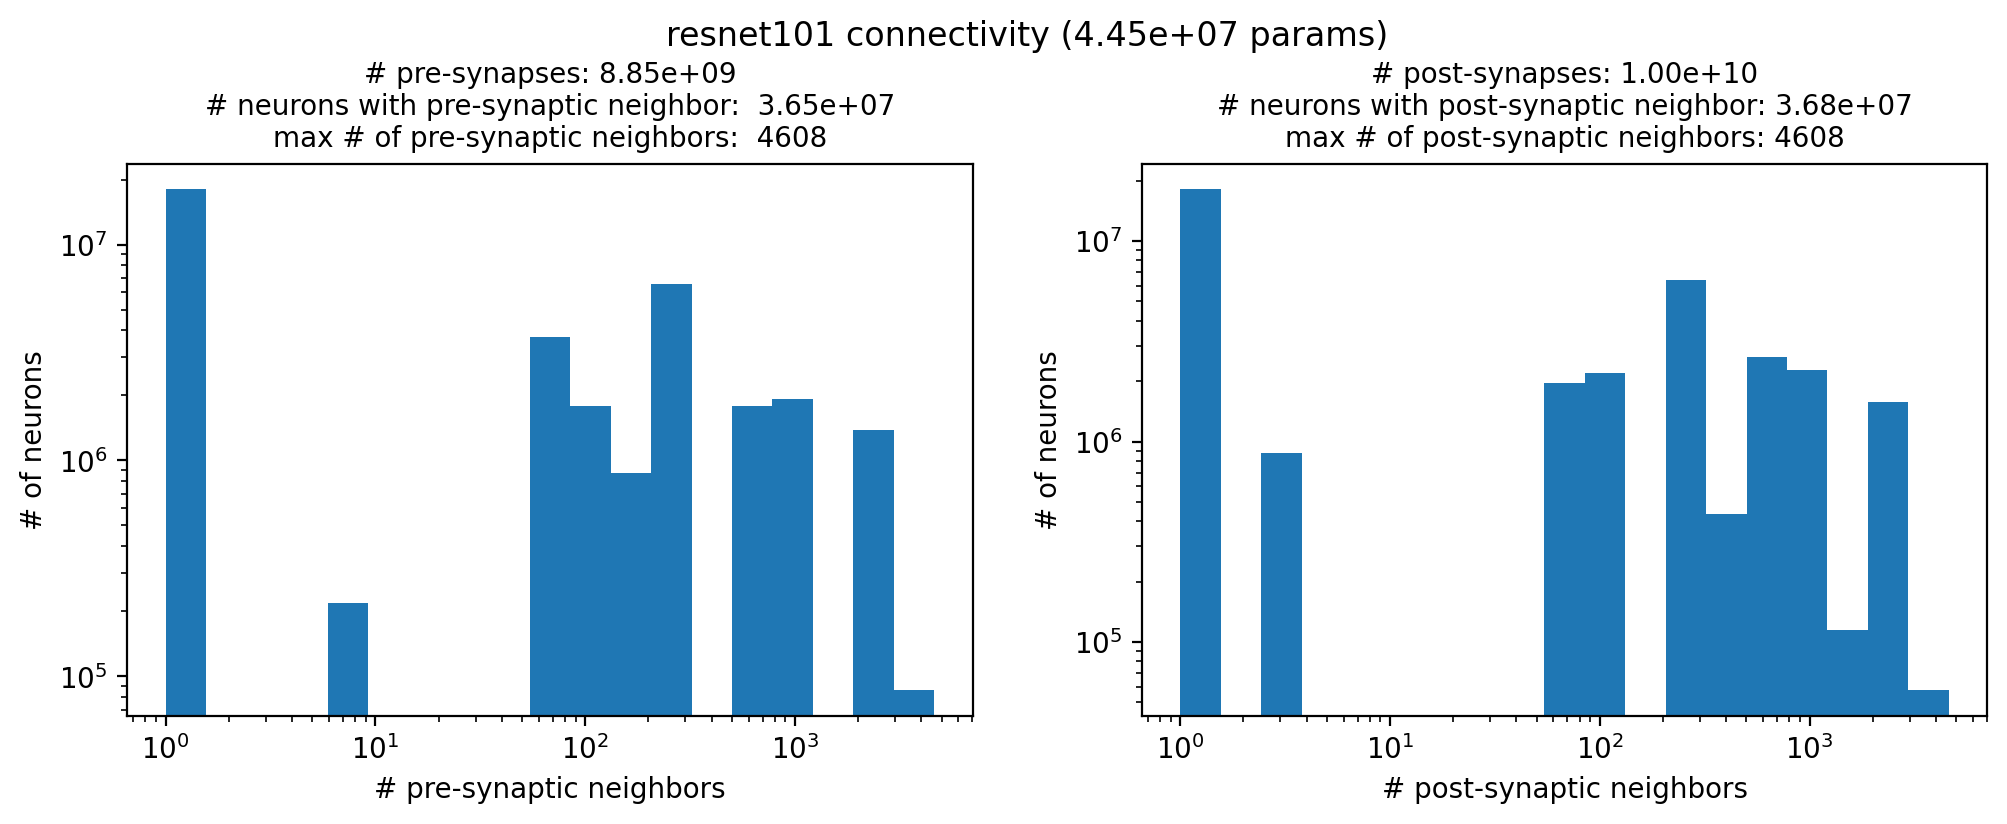

In [21]:
plt.figure(figsize=(12, 4), dpi=200)
plt.suptitle(f"{MODEL_NAME} connectivity ({utils.num_params(model):.2e} params)")
plt.subplots_adjust(top=0.8)

plt.subplot(1, 2, 1)
vals, weights = zip(*[(k, v) for k, v in PRE_COUNTS.items()])
utils.plot_loghist(vals, weights, bins=20)
plt.yscale("log")
plt.ylabel("# of neurons")
plt.xlabel("# pre-synaptic neighbors")
plt.title(
    "\n".join(
        (
            f"# pre-synapses: {sum(k * v for k, v in PRE_COUNTS.items()):.2e}",
            f"# neurons with pre-synaptic neighbor:  {sum(PRE_COUNTS.values()):.2e}",
            f"max # of pre-synaptic neighbors:  {max(PRE_COUNTS.keys())}",
        )
    ),
    fontsize=10,
)

plt.subplot(1, 2, 2)
vals, weights = zip(*[(k, v) for k, v in POST_COUNTS.items()])
utils.plot_loghist(vals, weights, bins=20)
plt.yscale("log")
plt.ylabel("# of neurons")
plt.xlabel("# post-synaptic neighbors")
plt.title(
    "\n".join(
        (
            f"# post-synapses: {sum(k * v for k, v in POST_COUNTS.items()):.2e}",
            f"# neurons with post-synaptic neighbor: {sum(POST_COUNTS.values()):.2e}",
            f"max # of post-synaptic neighbors: {max(POST_COUNTS.keys())}",
        )
    ),
    fontsize=10,
);